In [1]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 17.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/Colab Notebooks/Research/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

Mounted at /content/drive


# Scalar Value Functions

Iter 1/100 - Loss: 0.918
Iter 2/100 - Loss: 0.878
Iter 3/100 - Loss: 0.870
Iter 4/100 - Loss: 0.881
Iter 5/100 - Loss: 0.881
Iter 6/100 - Loss: 0.867
Iter 7/100 - Loss: 0.853
Iter 8/100 - Loss: 0.861
Iter 9/100 - Loss: 0.847
Iter 10/100 - Loss: 0.850
Iter 11/100 - Loss: 0.849
Iter 12/100 - Loss: 0.842
Iter 13/100 - Loss: 0.833
Iter 14/100 - Loss: 0.829
Iter 15/100 - Loss: 0.828
Iter 16/100 - Loss: 0.821
Iter 17/100 - Loss: 0.819
Iter 18/100 - Loss: 0.817
Iter 19/100 - Loss: 0.812
Iter 20/100 - Loss: 0.806
Iter 21/100 - Loss: 0.801
Iter 22/100 - Loss: 0.794
Iter 23/100 - Loss: 0.784
Iter 24/100 - Loss: 0.783
Iter 25/100 - Loss: 0.779
Iter 26/100 - Loss: 0.777
Iter 27/100 - Loss: 0.771
Iter 28/100 - Loss: 0.767
Iter 29/100 - Loss: 0.762
Iter 30/100 - Loss: 0.758
Iter 31/100 - Loss: 0.754
Iter 32/100 - Loss: 0.751
Iter 33/100 - Loss: 0.746
Iter 34/100 - Loss: 0.741
Iter 35/100 - Loss: 0.738
Iter 36/100 - Loss: 0.735
Iter 37/100 - Loss: 0.730
Iter 38/100 - Loss: 0.726
Iter 39/100 - Loss: 0

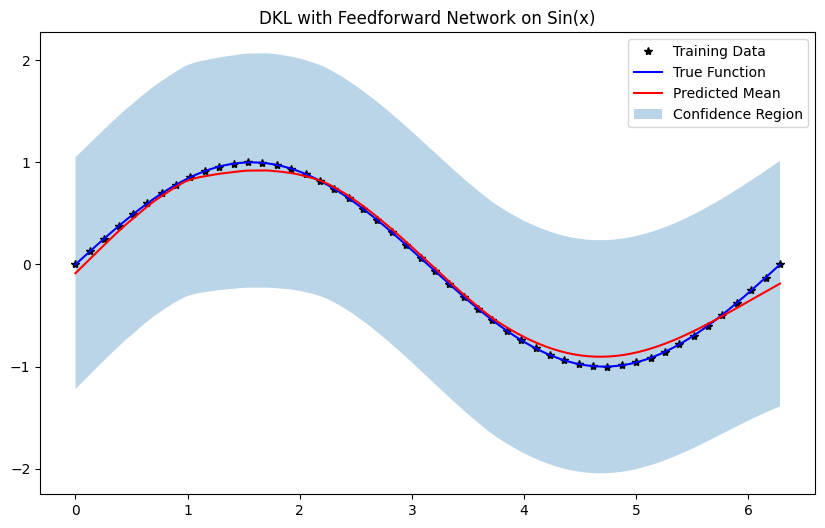

In [3]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate Sinusoidal Data
torch.manual_seed(42)
n_train = 50  # Number of training points
n_test = 200  # Number of test points

x_train = torch.linspace(0, 2 * torch.pi, n_train).view(-1, 1)
y_train = torch.sin(x_train).view(-1)
x_test = torch.linspace(0, 2 * torch.pi, n_test).view(-1, 1)
y_test = torch.sin(x_test).view(-1)

# Step 2: Define the Feedforward Neural Network
class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.fc1 = torch.nn.Linear(1, 50)
        self.fc2 = torch.nn.Linear(50, 20)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Step 3: Define the GP Model
class DKLModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, feature_extractor):
        super(DKLModel, self).__init__(train_x, train_y, likelihood)
        self.feature_extractor = feature_extractor
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        mean_x = self.mean_module(features)
        covar_x = self.covar_module(features)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Step 4: Set Up Likelihood and Model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
feature_extractor = FeatureExtractor()
model = DKLModel(x_train, y_train, likelihood, feature_extractor)

# Step 5: Train the Model
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 100
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    print(f"Iter {i + 1}/{n_iter} - Loss: {loss.item():.3f}")
    optimizer.step()

# Step 6: Evaluate the Model
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_preds = likelihood(model(x_test))
    mean = test_preds.mean
    lower, upper = test_preds.confidence_region()

# Step 7: Plot the Results
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_train.numpy(), 'k*', label='Training Data')
plt.plot(x_test.numpy(), y_test.numpy(), 'b', label='True Function')
plt.plot(x_test.numpy(), mean.numpy(), 'r', label='Predicted Mean')
plt.fill_between(x_test.numpy().flatten(), lower.numpy(), upper.numpy(), alpha=0.3, label='Confidence Region')
plt.legend()
plt.title('DKL with Feedforward Network on Sin(x)')
plt.show()


In [4]:
!pip install ace_tools

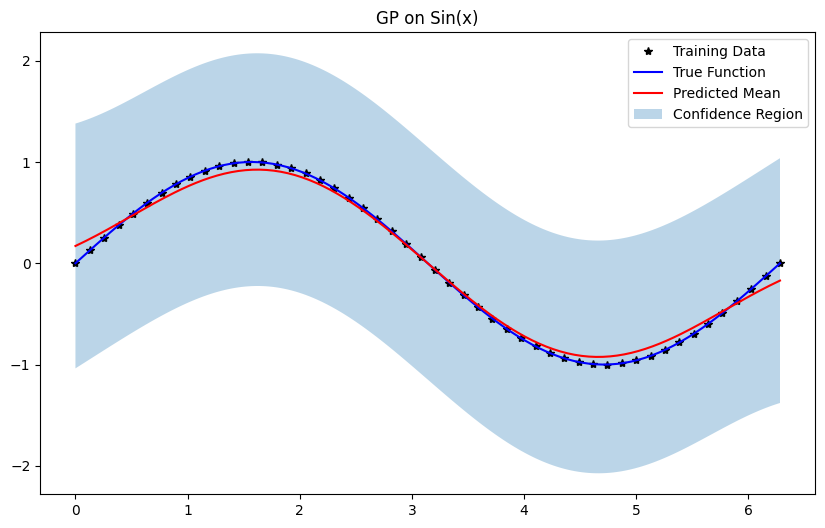

In [5]:
import torch
import gpytorch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Regular GP Model
class RegularGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(RegularGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Set up likelihood and GP model
likelihood_gp = gpytorch.likelihoods.GaussianLikelihood()
model_gp = RegularGP(x_train, y_train, likelihood_gp)

# Training the regular GP
model_gp.train()
likelihood_gp.train()

optimizer_gp = torch.optim.Adam([
    {'params': model_gp.parameters()},
    # {'params': likelihood_gp.parameters()},
], lr=0.01)

mll_gp = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_gp, model_gp)

for i in range(n_iter):
    optimizer_gp.zero_grad()
    output_gp = model_gp(x_train)
    loss_gp = -mll_gp(output_gp, y_train)
    loss_gp.backward()
    optimizer_gp.step()

# Evaluate both models
model.eval()
likelihood.eval()

model_gp.eval()
likelihood_gp.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    dkl_preds = likelihood(model(x_test))
    dkl_mean = dkl_preds.mean
    dkl_lower, dkl_upper = dkl_preds.confidence_region()

    gp_preds = likelihood_gp(model_gp(x_test))
    gp_mean = gp_preds.mean
    gp_lower, gp_upper = gp_preds.confidence_region()

# Step 7: Plot the Results
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_train.numpy(), 'k*', label='Training Data')
plt.plot(x_test.numpy(), y_test.numpy(), 'b', label='True Function')
plt.plot(x_test.numpy(), gp_mean.numpy(), 'r', label='Predicted Mean')
plt.fill_between(x_test.numpy().flatten(), gp_lower.numpy(), gp_upper.numpy(), alpha=0.3, label='Confidence Region')
plt.legend()
plt.title('GP on Sin(x)')
plt.show()

# import pandas as pd
# metrics_df = pd.DataFrame(metrics)
# print(metrics_df)

# Vector Valued Functions

## Data Pre-processing and EDA

In [6]:
import torch
import gpytorch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

# Step 1: Generate vector-valued outputs
x_train = torch.linspace(0, 2 * torch.pi, 50).view(-1, 1)
y_train = torch.cat([torch.sin(x_train), torch.cos(x_train)], dim=1)  # 2D output: [sin(x), cos(x)]

x_test = torch.linspace(0, 2 * torch.pi, 200).view(-1, 1)
y_test = torch.cat([torch.sin(x_test), torch.cos(x_test)], dim=1)

print(x_train.shape)
print(y_train.shape)

print(x_train[:5])
print(y_train[:5])

print(x_test.shape)
print(y_test.shape)
print(x_test[:5])
print(y_test[:5])

torch.Size([50, 1])
torch.Size([50, 2])
tensor([[0.0000],
        [0.1282],
        [0.2565],
        [0.3847],
        [0.5129]])
tensor([[0.0000, 1.0000],
        [0.1279, 0.9918],
        [0.2537, 0.9673],
        [0.3753, 0.9269],
        [0.4907, 0.8713]])
torch.Size([200, 1])
torch.Size([200, 2])
tensor([[0.0000],
        [0.0316],
        [0.0631],
        [0.0947],
        [0.1263]])
tensor([[0.0000, 1.0000],
        [0.0316, 0.9995],
        [0.0631, 0.9980],
        [0.0946, 0.9955],
        [0.1260, 0.9920]])


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_ocean_current_data_with_scalers(df, seq_length=10):
    """
    Preprocess ocean current time-series data for LSTM input with separate scalers.

    Args:
        df (pd.DataFrame): DataFrame with columns ["Date/Time", "Speed (knots)", "Dir (true)"].
        seq_length (int): Length of the time-series sequences for LSTM input.

    Returns:
        X (np.array): Input data for the LSTM of shape (num_sequences, seq_length, num_features).
        y (np.array): Target data for LSTM of shape (num_sequences, num_features).
        scalers (dict): Scalers used for Speed and Direction normalization.
    """
    # Convert Date/Time to discrete timesteps

    df['Timestep'] = np.arange(len(df))

    # Normalize Speed and Direction with separate scalers
    scaler_speed = MinMaxScaler()
    scaler_direction = MinMaxScaler()
    df['Speed (knots)'] = scaler_speed.fit_transform(df[['Speed (knots)']])
    df['Dir (true)'] = scaler_direction.fit_transform(df[['Dir (true)']])

    # Create sliding windows for LSTM input
    # X, y = [], []
    # for i in range(len(df) - seq_length):
    #     X.append(df[['Speed (knots)', 'Dir (true)']].iloc[i:i+seq_length].values)
    #     y.append(df[['Speed (knots)', 'Dir (true)']].iloc[i+seq_length].values)

    # X = np.array(X)
    # y = np.array(y)

    X = torch.tensor(np.arange(len(df)), dtype=torch.float32).view(-1, 1)
    y = torch.stack([
        torch.tensor(df['Speed (knots)'], dtype=torch.float32),
        torch.tensor(df['Dir (true)'], dtype = torch.float32),
    ], -1)

    # Return scalers for later denormalization
    scalers = {'speed': scaler_speed, 'direction': scaler_direction}
    return X, y, scalers

station = 'CHB0302'
data = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Research/data/{station}.csv')
data.columns = data.columns.str.strip()
df = pd.DataFrame(data)
X, y, scalers = preprocess_ocean_current_data_with_scalers(df)
print("X Shape:", X.shape)
print("Y Shape:", y.shape)
print(X[:5])
print(y[:5])


sample_size = 1000
splice = 50
# Split the data
X = X[:50]
y = y[:50]
# Calculate split index
split_index = int(0.9 * len(X))  # 80% for training
x_train, x_test = X[:split_index], X
y_train, y_test = y[:split_index], y


# Print shapes for verification
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Print a sample of training and testing data
print("Training data sample:")
print(x_train[:5], y_train[:5])

print("\nTesting data sample:")
print(x_test[:5], y_test[:5])

X Shape: torch.Size([6960, 1])
Y Shape: torch.Size([6960, 2])
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]])
tensor([[0.3091, 0.1944],
        [0.3000, 0.2028],
        [0.2727, 0.2417],
        [0.2545, 0.2389],
        [0.2545, 0.2333]])
x_train shape: torch.Size([45, 1]), y_train shape: torch.Size([45, 2])
x_test shape: torch.Size([50, 1]), y_test shape: torch.Size([50, 2])
Training data sample:
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]]) tensor([[0.3091, 0.1944],
        [0.3000, 0.2028],
        [0.2727, 0.2417],
        [0.2545, 0.2389],
        [0.2545, 0.2333]])

Testing data sample:
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]]) tensor([[0.3091, 0.1944],
        [0.3000, 0.2028],
        [0.2727, 0.2417],
        [0.2545, 0.2389],
        [0.2545, 0.2333]])


## Model Defs

In [8]:
class DKLModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, feature_extractor):
        super(DKLModel, self).__init__(train_x, train_y, likelihood)
        self.feature_extractor = feature_extractor
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        mean_x = self.mean_module(features).unsqueeze(-1).expand(-1, 2)
        covar_x = self.covar_module(features)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)



In [9]:
class RegularGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(RegularGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x).unsqueeze(-1).expand(-1, 2)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [10]:
# Define the LSTM feature extractor
class LSTMFeatureExtractor(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=10):
        super(LSTMFeatureExtractor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM expects input: (batch_size, sequence_length, input_size)
        x = x.unsqueeze(1)  # add an extra dim for sequence
        lstm_out, _ = self.lstm(x)
        # Take the last hidden state for each input
        last_hidden = lstm_out[:, -1, :]
        return self.fc(last_hidden)

class DKLModelWithLSTM(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, feature_extractor):
        super(DKLModelWithLSTM, self).__init__(train_x, train_y, likelihood)
        self.feature_extractor = feature_extractor
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=2
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        mean_x = self.mean_module(features).unsqueeze(-1).expand(-1, 2)
        covar_x = self.covar_module(features)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [11]:
# Define the Multi-Output GP model
class MultiOutputGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultiOutputGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.data_covar_module = gpytorch.kernels.RBFKernel()  # Input covariance
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=2, rank=1)  # Task covariance
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            self.data_covar_module, num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

## Train Models

In [12]:
def train_and_evaluate_model(model, likelihood, x_train, y_train, x_test, y_test, n_iter=500, lr=0.01, enable_print=True):
    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    likelihood = likelihood.to(device)
    x_train, y_train = x_train.to(device), y_train.to(device)
    x_test, y_test = x_test.to(device), y_test.to(device)

    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(n_iter):
        optimizer.zero_grad()
        output = model(x_train)
        loss = -mll(output, y_train)
        loss.backward()
        if enable_print and i % (n_iter // 10) == 0:
            print(f"Iter {i}/{n_iter} - Loss: {loss.item():.3f}")
        optimizer.step()

    print("#--- Done training ---#")
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = likelihood(model(x_test))
        mean = predictions.mean
        return mean.cpu()  # Move predictions back to CPU for further processing


In [13]:
# ## === Train Models === ##
# # GP
# likelihood_gp = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
# gp_model = RegularGP(x_train, y_train, likelihood_gp)
# gp_mean = train_and_evaluate_model(gp_model, likelihood_gp, x_train, y_train, x_test, y_test)

# # MOGP
# likelihood_mogp = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
# mogp_model = MultiOutputGP(x_train, y_train, likelihood_mogp)
# mogp_mean = train_and_evaluate_model(mogp_model, likelihood_mogp, x_train, y_train, x_test, y_test)

# # DKL + NN
# likelihood_dkl = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
# feature_extractor = FeatureExtractor()
# dkl_model = DKLModel(x_train, y_train, likelihood_dkl, feature_extractor)
# dkl_mean = train_and_evaluate_model(dkl_model, likelihood_dkl, x_train, y_train, x_test, y_test)

# # DKL + LSTM
# lstm_feature_extractor = LSTMFeatureExtractor(input_size=1, hidden_size=50, output_size=10)
# likelihood_lstm = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
# dkl_model_lstm = DKLModelWithLSTM(x_train, y_train, likelihood_lstm, lstm_feature_extractor)
# dkl_lstm_mean = train_and_evaluate_model(dkl_model_lstm, likelihood_lstm, x_train, y_train, x_test, y_test)

import time

## === Train Models with Timing === ##

# GP
start_time = time.time()
likelihood_gp = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
gp_model = RegularGP(x_train, y_train, likelihood_gp)
gp_mean = train_and_evaluate_model(gp_model, likelihood_gp, x_train, y_train, x_test, y_test)
gp_training_time = time.time() - start_time
print(f"GP training time: {gp_training_time:.2f} seconds\n")

# MOGP
start_time = time.time()
likelihood_mogp = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
mogp_model = MultiOutputGP(x_train, y_train, likelihood_mogp)
mogp_mean = train_and_evaluate_model(mogp_model, likelihood_mogp, x_train, y_train, x_test, y_test)
mogp_training_time = time.time() - start_time
print(f"MOGP training time: {mogp_training_time:.2f} seconds\n")

# DKL + NN
start_time = time.time()
likelihood_dkl = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
feature_extractor = FeatureExtractor()
dkl_model = DKLModel(x_train, y_train, likelihood_dkl, feature_extractor)
dkl_mean = train_and_evaluate_model(dkl_model, likelihood_dkl, x_train, y_train, x_test, y_test)
dkl_training_time = time.time() - start_time
print(f"DKL (NN) training time: {dkl_training_time:.2f} seconds\n")

# DKL + LSTM
start_time = time.time()
lstm_feature_extractor = LSTMFeatureExtractor(input_size=1, hidden_size=50, output_size=10)
likelihood_lstm = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
dkl_model_lstm = DKLModelWithLSTM(x_train, y_train, likelihood_lstm, lstm_feature_extractor)
dkl_lstm_mean = train_and_evaluate_model(dkl_model_lstm, likelihood_lstm, x_train, y_train, x_test, y_test)
dkl_lstm_training_time = time.time() - start_time
print(f"DKL (LSTM) training time: {dkl_lstm_training_time:.2f} seconds\n")



Iter 0/500 - Loss: 1.422
Iter 50/500 - Loss: 1.162
Iter 100/500 - Loss: 0.921
Iter 150/500 - Loss: 0.659
Iter 200/500 - Loss: 0.382
Iter 250/500 - Loss: 0.100
Iter 300/500 - Loss: -0.182
Iter 350/500 - Loss: -0.460
Iter 400/500 - Loss: -0.728
Iter 450/500 - Loss: -0.983
#--- Done training ---#
GP training time: 5.88 seconds

Iter 0/500 - Loss: 1.255
Iter 50/500 - Loss: 0.962
Iter 100/500 - Loss: 0.722
Iter 150/500 - Loss: 0.481
Iter 200/500 - Loss: 0.234
Iter 250/500 - Loss: -0.010
Iter 300/500 - Loss: -0.249
Iter 350/500 - Loss: -0.483
Iter 400/500 - Loss: -0.718
Iter 450/500 - Loss: -0.951
#--- Done training ---#
MOGP training time: 4.20 seconds

Iter 0/500 - Loss: 1.726
Iter 50/500 - Loss: 0.983
Iter 100/500 - Loss: 0.752
Iter 150/500 - Loss: 0.499
Iter 200/500 - Loss: 0.246
Iter 250/500 - Loss: -0.002
Iter 300/500 - Loss: -0.261
Iter 350/500 - Loss: -0.520
Iter 400/500 - Loss: -0.742
Iter 450/500 - Loss: -0.975
#--- Done training ---#
DKL (NN) training time: 4.68 seconds

Iter 0/50

## Plot Models

In [14]:
def plot_model_outputs(x_test, y_test, mean, lower, upper, model_name):
    x_test_np = x_test.numpy().flatten()
    y_test_np = y_test.numpy()
    mean_np = mean.numpy()
    lower_np = lower.numpy()
    upper_np = upper.numpy()

    plt.figure(figsize=(14, 6))

    # Left plot: sin(x)
    plt.subplot(1, 2, 1)
    plt.plot(x_test_np, y_test_np[:, 0], 'g--', label='True Speed')
    plt.plot(x_test_np, mean_np[:, 0], 'g-', label=f'{model_name} Prediction Speed')
    plt.fill_between(x_test_np, lower_np[:, 0], upper_np[:, 0], color='green', alpha=0.2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'{model_name}: Speed')
    plt.legend()

    # Right plot: cos(x)
    plt.subplot(1, 2, 2)
    plt.plot(x_test_np, y_test_np[:, 1], 'b--', label='True Direction')
    plt.plot(x_test_np, mean_np[:, 1], 'b-', label=f'{model_name} Prediction Direction')
    plt.fill_between(x_test_np, lower_np[:, 1], upper_np[:, 1], color='blue', alpha=0.2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'{model_name}: Direction')
    plt.legend()

    plt.tight_layout()
    plt.show()


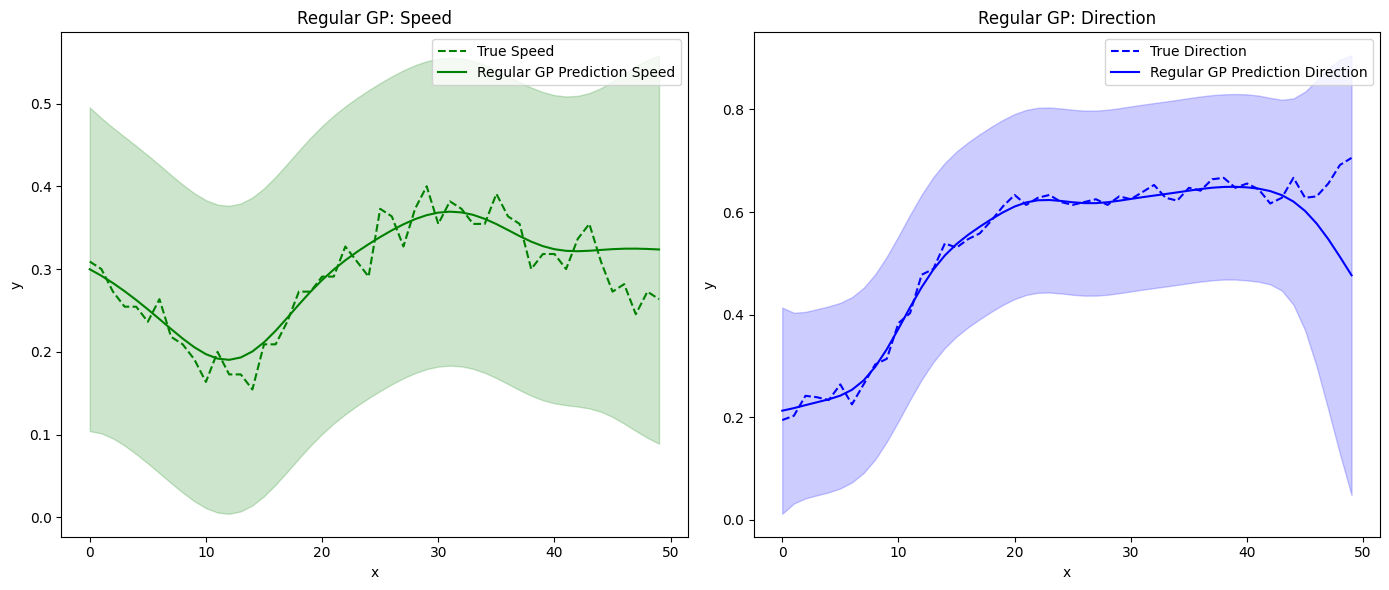

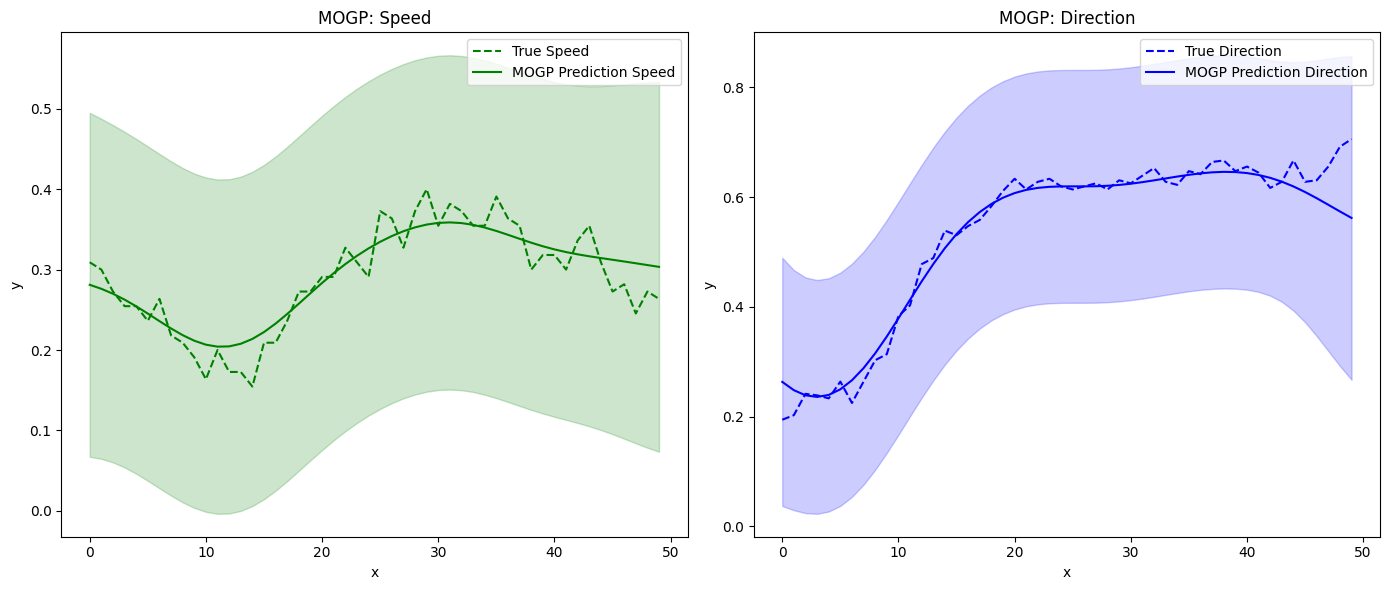

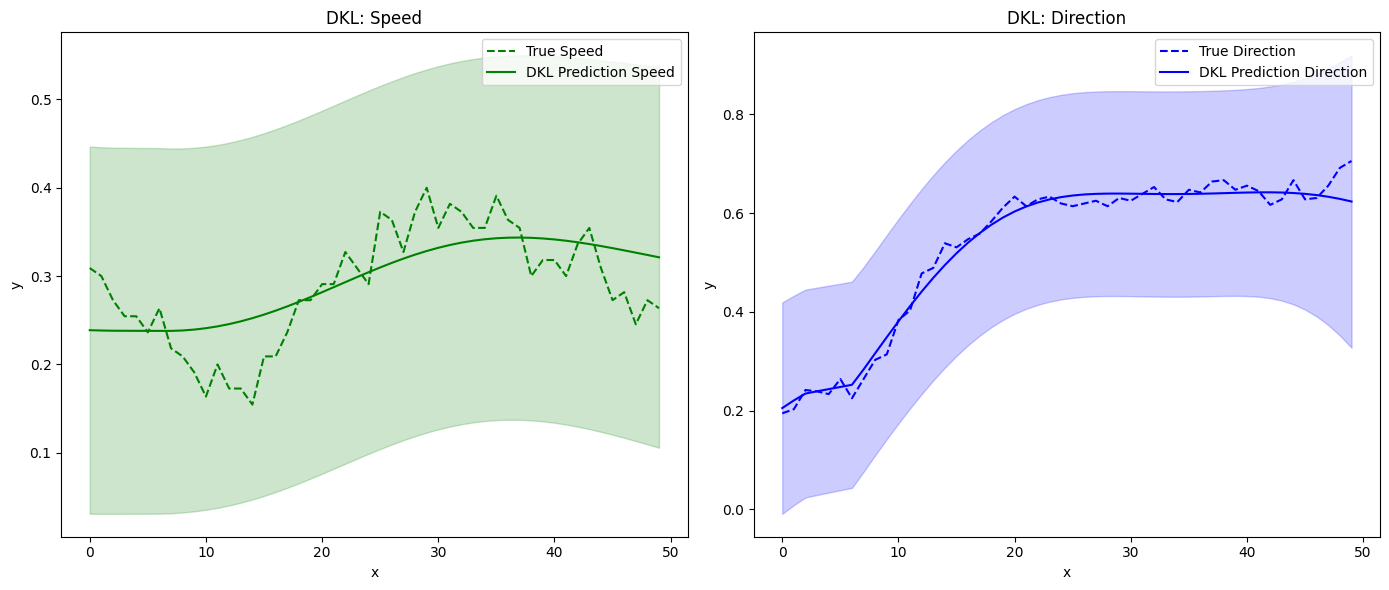

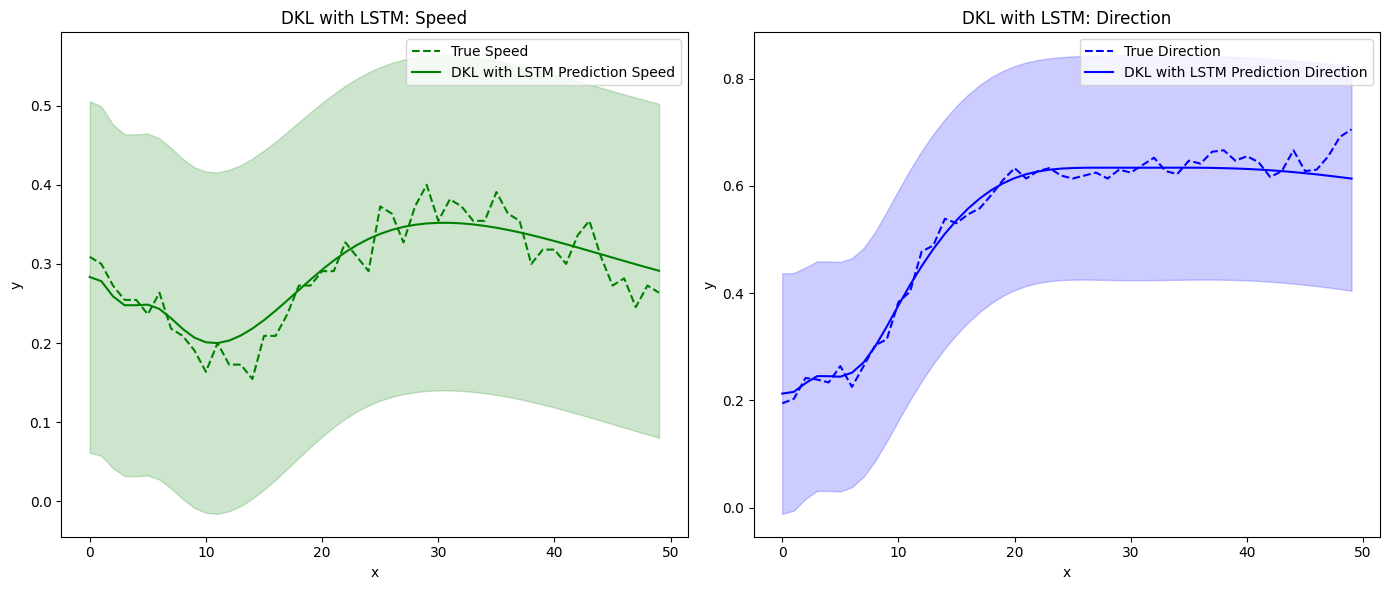

In [15]:
# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move data to the appropriate device
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# Move models to the same device
dkl_model = dkl_model.to(device)
gp_model = gp_model.to(device)
mogp_model = mogp_model.to(device)
dkl_model_lstm = dkl_model_lstm.to(device)

likelihood = likelihood.to(device)
likelihood_gp = likelihood_gp.to(device)
likelihood_mogp = likelihood_mogp.to(device)
likelihood_lstm = likelihood_lstm.to(device)

# Plot - GP
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    gp_preds = likelihood_gp(gp_model(x_test))
    gp_mean = gp_preds.mean
    lower_gp, upper_gp = gp_preds.confidence_region()

plot_model_outputs(x_test.cpu(), y_test.cpu(), gp_mean.cpu(), lower_gp.cpu(), upper_gp.cpu(), model_name="Regular GP")

# Plot - MOGP
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    mogp_preds = likelihood_mogp(mogp_model(x_test))
    mogp_mean = mogp_preds.mean
    lower_mogp, upper_mogp = mogp_preds.confidence_region()

plot_model_outputs(x_test.cpu(), y_test.cpu(), mogp_mean.cpu(), lower_mogp.cpu(), upper_mogp.cpu(), model_name="MOGP")

# # Plot - DKL
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    dkl_preds = likelihood_dkl(dkl_model(x_test))
    dkl_mean = dkl_preds.mean
    lower_dkl, upper_dkl = dkl_preds.confidence_region()

plot_model_outputs(x_test.cpu(), y_test.cpu(), dkl_mean.cpu(), lower_dkl.cpu(), upper_dkl.cpu(), model_name="DKL")


# # Plot - LSTM DKL
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    dkl_lstm_preds = likelihood_lstm(dkl_model_lstm(x_test))
    dkl_lstm_mean = dkl_lstm_preds.mean
    lower_dkl_lstm, upper_dkl_lstm = dkl_lstm_preds.confidence_region()

plot_model_outputs(x_test.cpu(), y_test.cpu(), dkl_lstm_mean.cpu(), lower_dkl_lstm.cpu(), upper_dkl_lstm.cpu(), model_name="DKL with LSTM")


### Latent Space

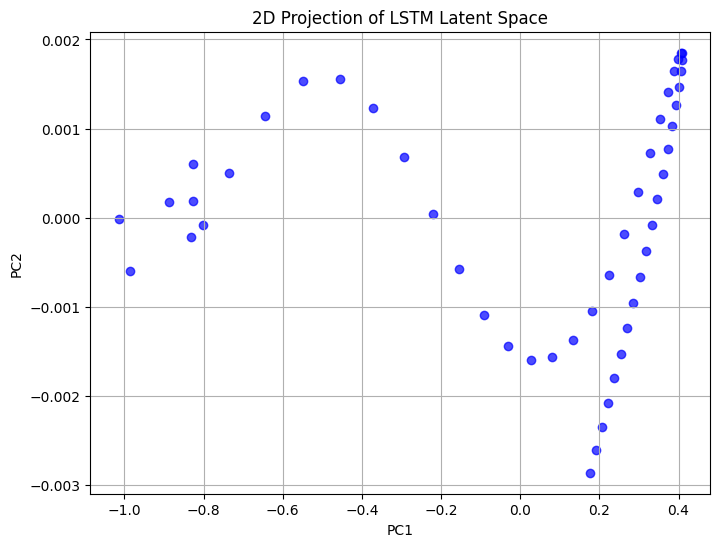

In [19]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Put the model in eval mode
dkl_model_lstm.eval()

# Assume x_test is your test input tensor
# Extract the latent features from the LSTM feature extractor
with torch.no_grad():
    latent_features = dkl_model_lstm.feature_extractor(x_test)  # shape: (N, latent_dim)

# Convert to numpy
latent_features_np = latent_features.cpu().numpy()

# Optional: reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_features_np)

# Plot the 2D latent space
plt.figure(figsize=(8,6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='blue', alpha=0.7)
plt.title("2D Projection of LSTM Latent Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


## Loss and Evaluations

In [16]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error

# # Predictions
# dkl_mean_np = dkl_mean.numpy() if 'dkl_mean' in locals() else np.zeros_like(y_test.numpy())
# gp_mean_np = gp_mean.numpy() if 'gp_mean' in locals() else np.zeros_like(y_test.numpy())
# dkl_lstm_mean_np = dkl_lstm_mean.numpy() if 'dkl_lstm_mean' in locals() else np.zeros_like(y_test.numpy())
# mogp_mean_np = mogp_mean.numpy() if 'mogp_mean' in locals() else np.zeros_like(y_test.numpy())

# # Error Functions
# def calculate_rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# def calculate_mse(y_true, y_pred):
#     return mean_squared_error(y_true, y_pred)

# # MSE and RMSE for each model
# y_test_np = y_test.numpy()
# mse_dkl = calculate_mse(y_test_np, dkl_mean_np)
# rmse_dkl = calculate_rmse(y_test_np, dkl_mean_np)

# mse_gp = calculate_mse(y_test_np, gp_mean_np)
# rmse_gp = calculate_rmse(y_test_np, gp_mean_np)

# mse_dkl_lstm = calculate_mse(y_test_np, dkl_lstm_mean_np)
# rmse_dkl_lstm = calculate_rmse(y_test_np, dkl_lstm_mean_np)

# mse_mogp = calculate_mse(y_test_np, mogp_mean_np)
# rmse_mogp = calculate_rmse(y_test_np, mogp_mean_np)

# # Table
# comparison = {
#     "Model": ["GP",
#               "MOGP",
#               "DKL + NN",
#               "DKL + LSTM"],
#     # "MSE": [mse_dkl, mse_gp, mse_dkl_lstm, mse_mogp],
#     "RMSE": [rmse_gp,
#              rmse_mogp,
#              rmse_dkl,
#              rmse_dkl_lstm],
# }
# comparison_df = pd.DataFrame(comparison)
# print(comparison_df.to_string(index=False))
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Ensure all predictions are moved to CPU for compatibility with numpy
dkl_mean_np = dkl_mean.cpu().numpy() if 'dkl_mean' in locals() else np.zeros_like(y_test.cpu().numpy())
gp_mean_np = gp_mean.cpu().numpy() if 'gp_mean' in locals() else np.zeros_like(y_test.cpu().numpy())
dkl_lstm_mean_np = dkl_lstm_mean.cpu().numpy() if 'dkl_lstm_mean' in locals() else np.zeros_like(y_test.cpu().numpy())
mogp_mean_np = mogp_mean.cpu().numpy() if 'mogp_mean' in locals() else np.zeros_like(y_test.cpu().numpy())

# Error Functions
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

# Ensure test targets are on CPU
y_test_np = y_test.cpu().numpy()

# MSE and RMSE for each model
mse_dkl = calculate_mse(y_test_np, dkl_mean_np)
rmse_dkl = calculate_rmse(y_test_np, dkl_mean_np)

mse_gp = calculate_mse(y_test_np, gp_mean_np)
rmse_gp = calculate_rmse(y_test_np, gp_mean_np)

mse_dkl_lstm = calculate_mse(y_test_np, dkl_lstm_mean_np)
rmse_dkl_lstm = calculate_rmse(y_test_np, dkl_lstm_mean_np)

mse_mogp = calculate_mse(y_test_np, mogp_mean_np)
rmse_mogp = calculate_rmse(y_test_np, mogp_mean_np)

# Table
comparison = {
    "Model": ["GP",
              "MOGP",
              "DKL + NN",
              "DKL + LSTM"],
    # "MSE": [mse_gp,
    #         mse_mogp,
    #         mse_dkl,
    #         mse_dkl_lstm],
    "RMSE": [rmse_gp,
             rmse_mogp,
             rmse_dkl,
             rmse_dkl_lstm],
}
comparison_df = pd.DataFrame(comparison)
print(comparison_df.to_string(index=False))


     Model     RMSE
        GP 0.037910
      MOGP 0.030574
  DKL + NN 0.034828
DKL + LSTM 0.024680


In [17]:
import pandas as pd
import numpy as np
import torch
import time
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

all_stations = ["CHB0302", "COI0420", "FLK1301", "HAI1102", "JOP1101"]
random_stations = all_stations

def preprocess_ocean_current_data_with_scalers(df, seq_length=10):
    df['Timestep'] = np.arange(len(df))

    scaler_speed = MinMaxScaler()
    scaler_direction = MinMaxScaler()
    df['Speed (knots)'] = scaler_speed.fit_transform(df[['Speed (knots)']])
    df['Dir (true)'] = scaler_direction.fit_transform(df[['Dir (true)']])

    X = torch.tensor(np.arange(len(df)), dtype=torch.float32).view(-1, 1)
    y = torch.stack([
        torch.tensor(df['Speed (knots)'], dtype=torch.float32),
        torch.tensor(df['Dir (true)'], dtype=torch.float32),
    ], -1)

    scalers = {'speed': scaler_speed, 'direction': scaler_direction}
    return X, y, scalers

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def train_and_record_metrics_for_station(station):
    # Load data
    data = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Research/data/{station}.csv')
    data.columns = data.columns.str.strip()
    df = pd.DataFrame(data)

    # Preprocess
    X, y, scalers = preprocess_ocean_current_data_with_scalers(df)

    # For demonstration, we limit data just like reference (adjust if needed)
    splice = 50
    X = X[:splice]
    y = y[:splice]
    split_index = int(0.9 * len(X))  # 90% train/test split as shown
    x_train, x_test = X[:split_index], X
    y_train, y_test = y[:split_index], y

    # Train each model and record metrics
    results = []

    # ===== GP Model =====
    start_time = time.time()
    likelihood_gp = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    gp_model = RegularGP(x_train, y_train, likelihood_gp)
    gp_mean = train_and_evaluate_model(gp_model, likelihood_gp, x_train, y_train, x_test, y_test)
    gp_training_time = time.time() - start_time

    # Move to CPU and numpy
    y_test_np = y_test.cpu().numpy()
    gp_mean_np = gp_mean.cpu().numpy()
    gp_rmse = calculate_rmse(y_test_np, gp_mean_np)
    gp_std = np.std(y_test_np - gp_mean_np)

    results.append({
        "Station": station,
        "Model": "GP",
        "RMSE": gp_rmse,
        "Std. Dev": gp_std,
        "Time": gp_training_time
    })

    # ===== MOGP Model =====
    start_time = time.time()
    likelihood_mogp = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    mogp_model = MultiOutputGP(x_train, y_train, likelihood_mogp)
    mogp_mean = train_and_evaluate_model(mogp_model, likelihood_mogp, x_train, y_train, x_test, y_test)
    mogp_training_time = time.time() - start_time

    mogp_mean_np = mogp_mean.cpu().numpy()
    mogp_rmse = calculate_rmse(y_test_np, mogp_mean_np)
    mogp_std = np.std(y_test_np - mogp_mean_np)

    results.append({
        "Station": station,
        "Model": "MOGP",
        "RMSE": mogp_rmse,
        "Std. Dev": mogp_std,
        "Time": mogp_training_time
    })

    # ===== DKL + NN Model =====
    start_time = time.time()
    likelihood_dkl = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    feature_extractor = FeatureExtractor()
    dkl_model = DKLModel(x_train, y_train, likelihood_dkl, feature_extractor)
    dkl_mean = train_and_evaluate_model(dkl_model, likelihood_dkl, x_train, y_train, x_test, y_test)
    dkl_training_time = time.time() - start_time

    dkl_mean_np = dkl_mean.cpu().numpy()
    dkl_rmse = calculate_rmse(y_test_np, dkl_mean_np)
    dkl_std = np.std(y_test_np - dkl_mean_np)

    results.append({
        "Station": station,
        "Model": "DKL + NN",
        "RMSE": dkl_rmse,
        "Std. Dev": dkl_std,
        "Time": dkl_training_time
    })

    # ===== DKL + LSTM Model =====
    start_time = time.time()
    lstm_feature_extractor = LSTMFeatureExtractor(input_size=1, hidden_size=50, output_size=10)
    likelihood_lstm = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    dkl_model_lstm = DKLModelWithLSTM(x_train, y_train, likelihood_lstm, lstm_feature_extractor)
    dkl_lstm_mean = train_and_evaluate_model(dkl_model_lstm, likelihood_lstm, x_train, y_train, x_test, y_test)
    dkl_lstm_training_time = time.time() - start_time

    dkl_lstm_mean_np = dkl_lstm_mean.cpu().numpy()
    dkl_lstm_rmse = calculate_rmse(y_test_np, dkl_lstm_mean_np)
    dkl_lstm_std = np.std(y_test_np - dkl_lstm_mean_np)

    results.append({
        "Station": station,
        "Model": "DKL + LSTM",
        "RMSE": dkl_lstm_rmse,
        "Std. Dev": dkl_lstm_std,
        "Time": dkl_lstm_training_time
    })

    return results

    # Detect device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move data to the appropriate device
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    # Move models to the same device
    dkl_model = dkl_model.to(device)
    gp_model = gp_model.to(device)
    mogp_model = mogp_model.to(device)
    dkl_model_lstm = dkl_model_lstm.to(device)

    likelihood = likelihood.to(device)
    likelihood_gp = likelihood_gp.to(device)
    likelihood_mogp = likelihood_mogp.to(device)
    likelihood_lstm = likelihood_lstm.to(device)

    # Plot - GP
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        gp_preds = likelihood_gp(gp_model(x_test))
        gp_mean = gp_preds.mean
        lower_gp, upper_gp = gp_preds.confidence_region()

    plot_model_outputs(x_test.cpu(), y_test.cpu(), gp_mean.cpu(), lower_gp.cpu(), upper_gp.cpu(), model_name="Regular GP")

    # Plot - MOGP
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        mogp_preds = likelihood_mogp(mogp_model(x_test))
        mogp_mean = mogp_preds.mean
        lower_mogp, upper_mogp = mogp_preds.confidence_region()

    plot_model_outputs(x_test.cpu(), y_test.cpu(), mogp_mean.cpu(), lower_mogp.cpu(), upper_mogp.cpu(), model_name="MOGP")

    # # Plot - DKL
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        dkl_preds = likelihood_dkl(dkl_model(x_test))
        dkl_mean = dkl_preds.mean
        lower_dkl, upper_dkl = dkl_preds.confidence_region()

    plot_model_outputs(x_test.cpu(), y_test.cpu(), dkl_mean.cpu(), lower_dkl.cpu(), upper_dkl.cpu(), model_name="DKL")


    # # Plot - LSTM DKL
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        dkl_lstm_preds = likelihood_lstm(dkl_model_lstm(x_test))
        dkl_lstm_mean = dkl_lstm_preds.mean
        lower_dkl_lstm, upper_dkl_lstm = dkl_lstm_preds.confidence_region()

    plot_model_outputs(x_test.cpu(), y_test.cpu(), dkl_lstm_mean.cpu(), lower_dkl_lstm.cpu(), upper_dkl_lstm.cpu(), model_name="DKL with LSTM")

# Now, loop over the 5 random stations and collect all results
all_results = []
for st in random_stations:
    station_results = train_and_record_metrics_for_station(st)
    all_results.extend(station_results)

# Create a DataFrame from the results
comparison_df = pd.DataFrame(all_results)
print(comparison_df)

# table of:
# Station | Model     | RMSE   | Std. Dev   | Time
# STN1    | GP        | ...    | ...        | ...
# STN1    | MOGP      | ...    | ...        | ...
# STN1    | DKL + NN  | ...    | ...        | ...
# STN1    | DKL + LSTM| ...    | ...        | ...
# STN2    | GP        | ...    | ...        | ...
# and so forth for all 5 stations.


Iter 0/500 - Loss: 1.353
Iter 50/500 - Loss: 1.031
Iter 100/500 - Loss: 0.746
Iter 150/500 - Loss: 0.496
Iter 200/500 - Loss: 0.246
Iter 250/500 - Loss: -0.001
Iter 300/500 - Loss: -0.243
Iter 350/500 - Loss: -0.482
Iter 400/500 - Loss: -0.719
Iter 450/500 - Loss: -0.950
#--- Done training ---#
Iter 0/500 - Loss: 1.433
Iter 50/500 - Loss: 1.148
Iter 100/500 - Loss: 0.883
Iter 150/500 - Loss: 0.616
Iter 200/500 - Loss: 0.339
Iter 250/500 - Loss: 0.058
Iter 300/500 - Loss: -0.222
Iter 350/500 - Loss: -0.496
Iter 400/500 - Loss: -0.761
Iter 450/500 - Loss: -1.013
#--- Done training ---#
Iter 0/500 - Loss: 1.697
Iter 50/500 - Loss: 0.969
Iter 100/500 - Loss: 0.738
Iter 150/500 - Loss: 0.501
Iter 200/500 - Loss: 0.246
Iter 250/500 - Loss: -0.001
Iter 300/500 - Loss: -0.216
Iter 350/500 - Loss: -0.486
Iter 400/500 - Loss: -0.720
Iter 450/500 - Loss: -0.940
#--- Done training ---#
Iter 0/500 - Loss: 1.150
Iter 50/500 - Loss: 0.942
Iter 100/500 - Loss: 0.724
Iter 150/500 - Loss: 0.486
Iter 200